# **GENETIC ALGORITHM (GA)**
**Inspired by natural evolution, GAs efficiently explore the solution space to discover optimal or near-optimal solutions, even for complex problems with multiple moving parts. By mimicking the process of natural selection, GAs can evolve solutions over time, improving their performance iteratively. The natural selection process is mirrored in GA by selecting individuals with higher fitness scores for reproduction. In this way, they pass on their favorable traits, or "genes," to the next generation. Potential solutions to a problem are represented as "chromosomes," which are typically coded as strings or arrays. Each element in the chromosome corresponds to a gene that determines a specific trait of the solution. Crossover is a genetic operation that combines parts of the genetic material of two parent chromosomes into a new chromosome that has parts of each parent. Mutation introduces random changes to an organism's genes, which can lead to new traits. A fitness function evaluates how well a solution solves the problem at hand. Solutions with higher fitness scores are more likely to be selected for reproduction, ensuring that better solutions propagate through generations.**
##### **This notebook shows an practical implementation of this algorithm. Genetic algorithm will be used to find the combination of values for a, b, and c that results in the flattest parabola of the equation y=ax2+bx+c.**

In [2]:
# Libraries 
import random
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

In [3]:
# Define the fitness function (objective is to create the flattest U-shape) - since se want to find the flattest graphed u-shape, we calculate the y value at the vertex and at x=-1 and x=1.
def fitness_function(params):
    a, b, c = params
    if a <= 0:
        return -float('inf')  # Penalize downward facing u-shapes heavily
    vertex_x = -b / (2 * a) # x value at vertex
    vertex_y = a * (vertex_x ** 2) + b * vertex_x + c # y value at vertex
    y_left = a * (-1) ** 2 + b * (-1) + c # y-coordinate at x = -1
    y_right = a * (1) ** 2 + b * (1) + c # y-coordinate at x = 1
    curviness = abs(y_left - vertex_y) + abs(y_right - vertex_y) # the difference in y value at the three points calculated above.
    return -curviness  # Negate to minimize curviness

In [4]:
# Create the initial population
def create_initial_population(size, lower_bound, upper_bound):
    population = []
    for _ in range(size):
        individual = (random.uniform(lower_bound, upper_bound),
                    random.uniform(lower_bound, upper_bound),
                    random.uniform(lower_bound, upper_bound)) # generate a population of random solutions (a, b, and c)
        population.append(individual)
    return population

In [5]:
# Selection function using tournament selection - this function will determine which individuals reproduce to create the next population.
def selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size) # a random subset of individuals in the population is taken
        winner = max(tournament, key=lambda x: x[1])[0] # within this subset, the individuals with the largest fitness will be selected for reproduction.
        selected.append(winner)
    return selected

In [6]:
# Crossover function - creates new solutions based on existing solutions.
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = tuple(alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2))
    child2 = tuple(alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2))
    return child1, child2

In [7]:
# Mutation function - introduce randomness to subsequent generations (diversity). 
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    individual = list(individual)
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-1, 1)
            individual[i] += mutation_amount
            # Ensure the individual stays within bounds
            individual[i] = max(min(individual[i], upper_bound), lower_bound)
    return tuple(individual)

In [8]:
# Genetic algorithm function
def genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate):
    population = create_initial_population(population_size, lower_bound, upper_bound)
    
    # Prepare for plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows, 1 column for subplots
    best_performers = []
    all_populations = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", "a", "b", "c", "Fitness"]

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        # Store the best performer of the current generation
        best_individual = max(population, key=fitness_function)
        best_fitness = fitness_function(best_individual)
        best_performers.append((best_individual, best_fitness))
        all_populations.append(population[:])
        table.add_row([generation + 1, best_individual[0], best_individual[1], best_individual[2], best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)

            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

        # Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    # Print the table
    print(table)

    # Plot the population of one generation (last generation)
    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]

    axs[0].scatter(range(len(final_population)), [ind[0] for ind in final_population], color='blue', label='a')
    axs[0].scatter([final_population.index(best_individual)], [best_individual[0]], color='cyan', s=100, label='Best Individual a')
    axs[0].set_ylabel('a', color='blue')
    axs[0].legend(loc='upper left')
    
    axs[1].scatter(range(len(final_population)), [ind[1] for ind in final_population], color='green', label='b')
    axs[1].scatter([final_population.index(best_individual)], [best_individual[1]], color='magenta', s=100, label='Best Individual b')
    axs[1].set_ylabel('b', color='green')
    axs[1].legend(loc='upper left')
    
    axs[2].scatter(range(len(final_population)), [ind[2] for ind in final_population], color='red', label='c')
    axs[2].scatter([final_population.index(best_individual)], [best_individual[2]], color='yellow', s=100, label='Best Individual c')
    axs[2].set_ylabel('c', color='red')
    axs[2].set_xlabel('Individual Index')
    axs[2].legend(loc='upper left')
    
    axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    # Plot the values of a, b, and c over generations
    generations_list = range(1, len(best_performers) + 1)
    a_values = [ind[0][0] for ind in best_performers]
    b_values = [ind[0][1] for ind in best_performers]
    c_values = [ind[0][2] for ind in best_performers]
    fig, ax = plt.subplots()
    ax.plot(generations_list, a_values, label='a', color='blue')
    ax.plot(generations_list, b_values, label='b', color='green')
    ax.plot(generations_list, c_values, label='c', color='red')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend()

    # Plot the fitness values over generations
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = [min([fitness_function(ind) for ind in population]) for population in all_populations]
    max_fitness_values = [max([fitness_function(ind) for ind in population]) for population in all_populations]
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend()

    # Plot the quadratic function for each generation
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, generations))
    for i, (best_ind, best_fit) in enumerate(best_performers):
        color = colors[i]
        a, b, c = best_ind
        x_range = np.linspace(lower_bound, upper_bound, 400)
        y_values = a * (x_range ** 2) + b * x_range + c
        ax.plot(x_range, y_values, color=color)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadratic Function')

    # Create a subplot for the colorbar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    norm = plt.cm.colors.Normalize(vmin=0, vmax=generations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical', label='Generation')

    plt.show()

    return max(population, key=fitness_function)

+------------+---------------------+----------------------+---------------------+----------------------+
| Generation |          a          |          b           |          c          |       Fitness        |
+------------+---------------------+----------------------+---------------------+----------------------+
|     1      |   9.09602441262576  |  6.319138186083293   |  19.564407142078252 |  -20.3870466398676   |
|     2      |  9.005280821147483  |  0.6776903862311443  |  14.728246189117725 |  -18.03606136122165  |
|     3      |  6.387594047577439  |  3.266570426041336   |  -8.49018156162626  | -13.610438603312545  |
|     4      |  6.673863210135984  | 0.43566604254967367  | -13.820351091090442 | -13.361946437573387  |
|     5      |   6.31721454002672  |  2.271023794928118   |  -8.743989243806308 | -13.042642941119166  |
|     6      |  5.8669610751872145 |  1.1003084837013544  |  -10.08987490054738 |  -11.83709982138587  |
|     7      |   4.96711409668292  | 0.1036849806213635

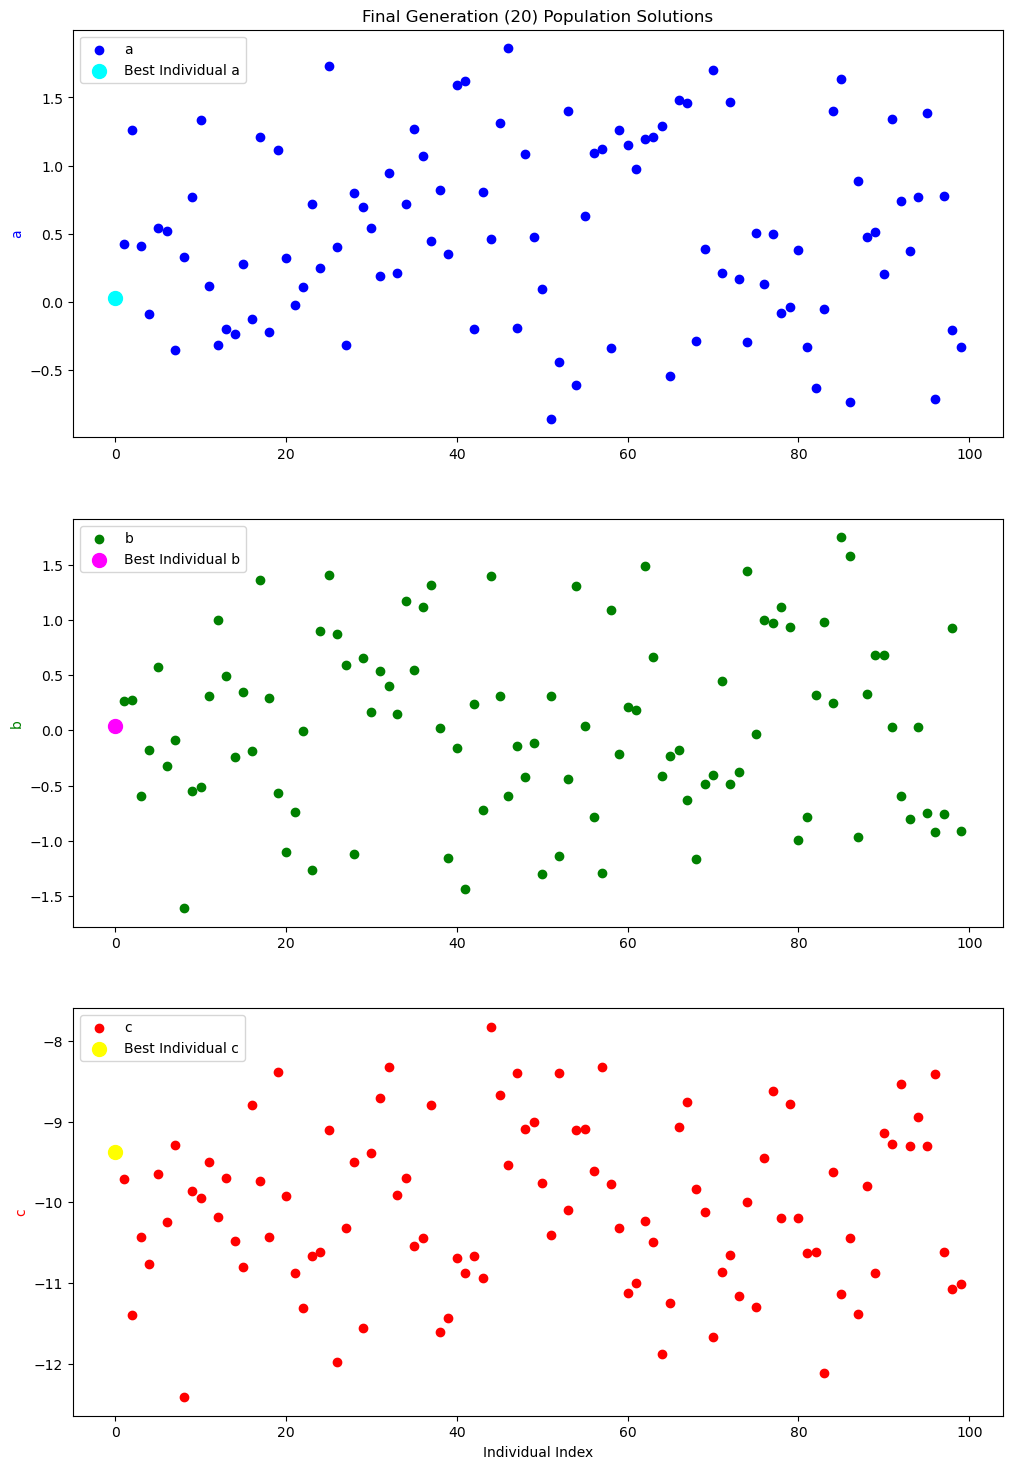

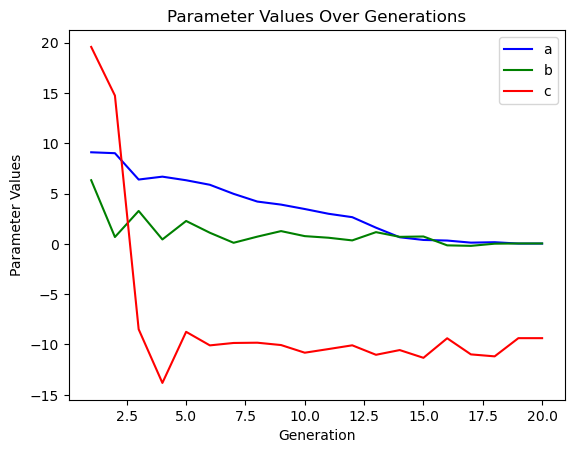

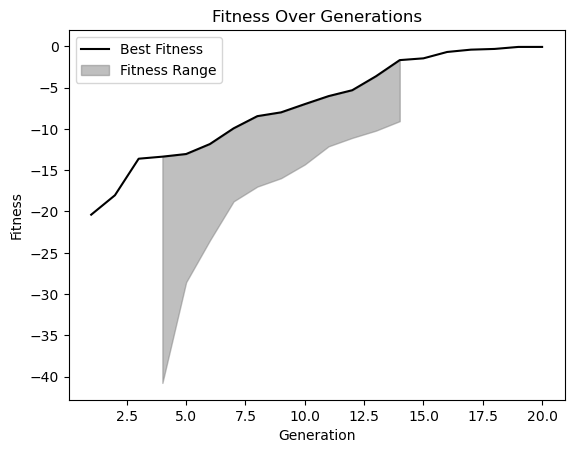

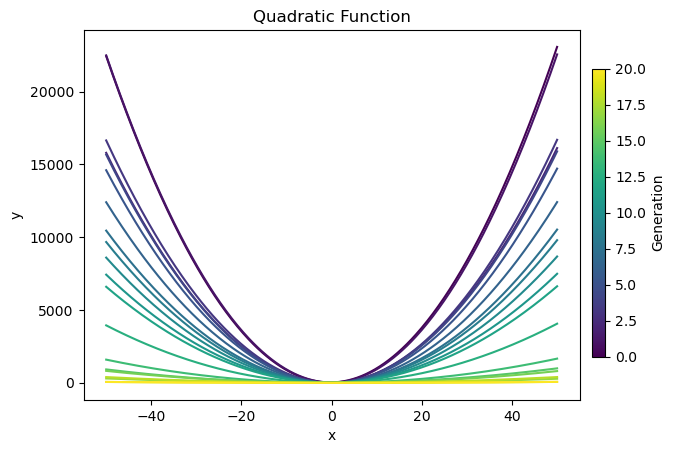

Best solution found: a = 0.02586102257856926, b = 0.036475769127989666, c = -9.372557082175945


In [9]:
# Parameters for the genetic algorithm
population_size = 100
lower_bound = -50
upper_bound = 50
generations = 20
mutation_rate = 1

# Run the genetic algorithm
best_solution = genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate)
print(f"Best solution found: a = {best_solution[0]}, b = {best_solution[1]}, c = {best_solution[2]}")